# ZILLOW - Part 1

# Abstract


This document follows a 7 steps solution workflow exposed in the Data Science Solutions book from Manav Shegal:

1. Question or Problem Definition
2. Acquire Training and Testing Data
3. Wrangle, Prepare and Cleanse the Data
4. Analyze, Identify Patterns and Explore the Data
5. Model, Predict and Solve the Problem
6. Visualise, Report and Present the Problem Solving Steps and Final Solution
7. Supply or Submit the Results

# Project

## Question or Problem Definition

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important. The Zestimate was created to give consumers as much information as possible about homes and the housing market, marking the first time consumers had access to this type of home value information at no cost.

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property.

The contest can be broken down in two parts:  
1. In the qualifying round, contestants build a model to improve the Zestimate residual error.
2. In the final round, participants build a home valuation algorithm from the ground up, using external data sources to help engineer new features that give their model an edge over the competition.

The task at hand focuses on the first part of this challenge.

Submissions are evaluated on **Mean Absolute Error** between the predicted log error and the actual log error. The log error is defined as 

$$log(error) = log(Zestimate) - log(SalePrice)$$

## Acquire Training and Testing Data

### Import libraries

In [148]:
# stop printing warnings
import warnings; warnings.simplefilter('ignore')

# data structures and data analysis tools
import pandas as pd

# scientific computing
import numpy as np

# operating system
import os

# visualisation
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

# default matplotlib plotting style
plt.style.use('ggplot')

# data mining and data analysis
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_tree

### Options

In [2]:
# set number of rows displayed
pd.set_option('display.max_row', 60)

# display multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Path

In [3]:
# get the current working directory
cwd = os.getcwd()
print(cwd)


# set the path of the project
path_project = "/Users/manuelsteiner/Documents/Kaggle/Zillow/input/"
print(path_project)

/Users/manuelsteiner/Documents/Kaggle/Zillow
/Users/manuelsteiner/Documents/Kaggle/Zillow/input/


### Read the files

In [4]:
transactions = pd.read_csv(os.path.join(path_project, "train_2016_v2.csv"))
                          
# os.path.join. automatically detects the operating system and format the path accordingly.

In [5]:
properties = pd.read_csv(os.path.join(path_project, "properties_2016.csv"), low_memory = False)

In [6]:
sample_submission = pd.read_csv(os.path.join(path_project, "sample_submission.csv"))

### Have a Peak at the datasets

In [7]:
transactions.head()
properties.head()
sample_submission.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


### Basic information

Having duplicates in the datasets might lead to overfitting when training a regression model.

In [8]:
data = {'transactions': transactions, 'properties': properties, 'sample_submission':sample_submission}

pd.DataFrame({'dataset':list(data.keys()), \
              'duplicates': list(({key: value.duplicated().sum() for key,value in data.items()}).values()), \
              'rows': list(({key: value.shape[0] for key,value in data.items()}).values()), \
              'columns': list(({key: value.shape[1] for key,value in data.items()}).values())}) \
                .set_index('dataset')


,duplicates,rows,columns
dataset,,,
transactions,0,90275,3
properties,0,2985217,58
sample_submission,0,2985217,7


The table above confirms that the datasets are free of duplicates, so this is one less source of potential overfitting.

**What features are available?**

#### transactions

In [9]:
data['transactions'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Data columns (total 3 columns):
parcelid           90275 non-null int64
logerror           90275 non-null float64
transactiondate    90275 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ MB


#### properties

In [10]:
data['properties'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
parcelid                        int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottub

#### sample submission

In [11]:
data['sample_submission'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 7 columns):
ParcelId    int64
201610      int64
201611      int64
201612      int64
201710      int64
201711      int64
201712      int64
dtypes: int64(7)
memory usage: 159.4 MB


These three datasets seem to have a common key - *parcelid*. We will check the level of the *Transactions* and *Properties* datasets and see if we can join them on this variable. We want here to link all the properties characteristics with their transactions in order to create the dataframe that will be used to explore the data and build a predictive model.

### Create a dataframe

In [12]:
# number of rows in the "transactions" dataset
len(transactions)

# number of unique "parcelid" values
transactions['parcelid'].nunique()

# keys of the "transactions" dataset
len(transactions.groupby(['parcelid', 'transactiondate']).nunique())


90275

90150

90275

The ***Transactions*** dataset is unique at the following levels:
* *parcelid*
* *transactiondate*


Some of properties have been sold many times during the period considered:

In [13]:
transactions['parcelid'].value_counts() \
                        .value_counts(sort = True, ascending = True)

3        1
2      123
1    90026
Name: parcelid, dtype: int64

- 123 properties have been sold two times
- 1 has been sold three times

In [14]:
# number of rows in the "properties" dataset
len(properties)

# number of unique "parcelid" values
properties['parcelid'].nunique()

2985217

2985217

The ***Properties*** dataset is then unique at the following level:
* *parcelid*



We can verify whether each unique *parcelid* in the ***Transaction*** dataset appears in the ***Properties*** dataset.

In [15]:
transactions['parcelid'].drop_duplicates().astype('str')\
    .isin(properties['parcelid'].astype('str'))\
    .sum()

90150

Each *parcelid* in the ***Transactions*** dataset can be found in the ***Properties*** dataset.


#### Rename the features of the "Properties" dataset

In [16]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
parcelid                        int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottub

In [17]:
properties.rename(columns={
          'transactiondate': 'transaction_date',\
          'yearbuilt': 'build_year',\
          'basementsqft': 'area_basement', \
          'yardbuildingsqft17': 'area_patio', \
          'yardbuildingsqft26': 'area_shed', \
          'poolsizesum': 'area_pool', \
          'lotsizesquarefeet': 'area_lot', \
          'garagetotalsqft': 'area_garage', \
          'finishedfloor1squarefeet': 'area_firstfloor_finished', \
          'calculatedfinishedsquarefeet': 'area_total_calc', \
          'finishedsquarefeet6': 'area_base', \
          'finishedsquarefeet12': 'area_live_finished', \
          'finishedsquarefeet13': 'area_liveperi_finished', \
          'finishedsquarefeet15': 'area_total_finished', \
          'finishedsquarefeet50': 'area_unknown', \
          'unitcnt': 'num_unit', \
          'numberofstories': 'num_story', \
          'roomcnt': 'num_room', \
          'bathroomcnt': 'num_bathroom', \
          'bedroomcnt': 'num_bedroom', \
          'calculatedbathnbr': 'num_bathroom_calc', \
          'fullbathcnt': 'num_bath', \
          'threequarterbathnbr': 'num_75_bath', \
          'fireplacecnt': 'num_fireplace', \
          'poolcnt': 'num_pool', \
          'garagecarcnt': 'num_garage', \
          'regionidcounty': 'region_county', \
          'regionidcity': 'region_city', \
          'regionidzip': 'region_zip', \
          'regionidneighborhood': 'region_neighbor', \
          'taxvaluedollarcnt': 'tax_total', \
          'structuretaxvaluedollarcnt': 'tax_building', \
          'landtaxvaluedollarcnt': 'tax_land', \
          'taxamount': 'tax_property', \
          'assessmentyear': 'tax_year', \
          'taxdelinquencyflag': 'tax_delinquency_flag', \
          'taxdelinquencyyear': 'tax_delinquency_year', \
          'propertyzoningdesc': 'zoning_property', \
          'propertylandusetypeid': 'zoning_landuse', \
          'propertycountylandusecode': 'zoning_landuse_county', \
          'fireplaceflag': 'flag_fireplace', \
          'hashottuborspa': 'flag_tub', \
          'buildingqualitytypeid': 'quality', \
          'buildingclasstypeid': 'framing', \
          'typeconstructiontypeid': 'material', \
          'decktypeid': 'deck', \
          'storytypeid': 'story', \
          'heatingorsystemtypeid': 'heating', \
          'airconditioningtypeid': 'aircon', \
          'architecturalstyletypeid': 'architectural_style'
          }, inplace=True)

#### Create the dataframe used for model building

We can now build the dataframe that will be used for exploration, training and testing, by joining on the *parcelid* key. 

In [29]:
df = transactions.merge(properties, how = 'inner', on = 'parcelid')
df.shape

(90275, 60)

The resulting dataframe has 90,275 rows and 60 columns. 

**What are the features in the resulting dataframe?**

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 60 columns):
parcelid                    90275 non-null int64
logerror                    90275 non-null float64
transactiondate             90275 non-null object
aircon                      28781 non-null float64
architectural_style         261 non-null float64
area_basement               43 non-null float64
num_bathroom                90275 non-null float64
num_bedroom                 90275 non-null float64
framing                     16 non-null float64
quality                     57364 non-null float64
num_bathroom_calc           89093 non-null float64
deck                        658 non-null float64
area_firstfloor_finished    6856 non-null float64
area_total_calc             89614 non-null float64
area_live_finished          85596 non-null float64
area_liveperi_finished      33 non-null float64
area_total_finished         3564 non-null float64
area_unknown                6856 non-null 

### Datetime features

What are the types of the date features?

In [31]:
dates_features = df[['transactiondate', 'build_year', 'tax_year', 'tax_delinquency_year']]
dates_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 4 columns):
transactiondate         90275 non-null object
build_year              89519 non-null float64
tax_year                90275 non-null float64
tax_delinquency_year    1783 non-null float64
dtypes: float64(3), object(1)
memory usage: 3.4+ MB


What do their unique values look like?

In [32]:
for i in dates_features.columns:
    print(i, "\n", "\n", dates_features[i].unique(), "\n")

transactiondate 
 
 ['2016-01-01' '2016-01-02' '2016-01-03' '2016-01-04' '2016-01-05'
 '2016-06-29' '2016-01-06' '2016-09-12' '2016-06-17' '2016-01-07'
 '2016-09-14' '2016-07-05' '2016-01-08' '2016-06-27' '2016-08-04'
 '2016-05-19' '2016-01-09' '2016-01-10' '2016-01-11' '2016-09-15'
 '2016-06-14' '2016-01-12' '2016-01-13' '2016-09-17' '2016-06-10'
 '2016-01-14' '2016-01-15' '2016-10-12' '2016-01-16' '2016-01-17'
 '2016-01-18' '2016-01-19' '2016-09-30' '2016-12-28' '2016-06-06'
 '2016-01-20' '2016-01-21' '2016-09-20' '2016-10-11' '2016-01-22'
 '2016-01-23' '2016-01-24' '2016-01-25' '2016-08-26' '2016-01-26'
 '2016-06-01' '2016-04-14' '2016-08-16' '2016-09-23' '2016-01-27'
 '2016-01-28' '2016-07-01' '2016-01-29' '2016-09-09' '2016-08-09'
 '2016-06-16' '2016-01-30' '2016-01-31' '2016-02-01' '2016-09-02'
 '2016-02-02' '2016-02-03' '2016-02-04' '2016-05-24' '2016-02-05'
 '2016-04-27' '2016-08-30' '2016-02-06' '2016-02-07' '2016-08-29'
 '2016-02-08' '2016-05-09' '2016-02-09' '2016-02-10' '20

As can be seen above, *tax_year* has zero missing values and only one value "2015". As it does not have any variance, we can delete this variable from the dataframe:

In [33]:
# delete feature
df.drop("tax_year", inplace = True, axis = 1)

*build_year* is already in float64 and in the right format, so it's all good. As to *tax_delinquency_year*, we can recode the values:

In [34]:
# unique values
df['tax_delinquency_year'].unique()

# year conversion dictionary
values_dict = {99: 1999, 6: 2006, 7: 2007, 8: 2008, 9:2009, 10:2010, 11: 2011, 12:2012, 13:2013, 14:2014, 15:2015}

# map the dictionary
df['tax_delinquency_year'] = df['tax_delinquency_year'].map(values_dict)

# unique values after transformation
df['tax_delinquency_year'].unique()

array([nan, 13., 15., 12., 14., 10.,  9.,  8., 11.,  7.,  6., 99.])

array([  nan, 2013., 2015., 2012., 2014., 2010., 2009., 2008., 2011.,
       2007., 2006., 1999.])

### Categorical features

In [38]:
categorical_features = df.select_dtypes(include='object')
categorical_features.columns

Index(['transactiondate', 'flag_tub', 'zoning_landuse_county',
       'zoning_property', 'flag_fireplace', 'tax_delinquency_flag'],
      dtype='object')

In [39]:
categorical_features.head()

,transactiondate,flag_tub,zoning_landuse_county,zoning_property,flag_fireplace,tax_delinquency_flag
0,2016-01-01,NaN,0100,LARS,NaN,NaN
1,2016-01-01,NaN,1,NaN,NaN,NaN
2,2016-01-01,NaN,0100,PSR6,NaN,NaN
3,2016-01-02,NaN,010C,LAR3,NaN,NaN
4,2016-01-02,NaN,122,NaN,NaN,NaN


How many unique values have each of these categorical variables?

In [40]:
categorical_features.describe()

,transactiondate,flag_tub,zoning_landuse_county,zoning_property,flag_fireplace,tax_delinquency_flag
count,90275,2365,90274,58313,222,1783
unique,352,1,77,1996,1,1
top,2016-07-29,True,0100,LAR1,True,Y
freq,910,2365,30846,7678,222,1783


*zoning_landuse_county* and *zoning_property* seem to have many levels. This might be a sign of high cardinality (large number of levels where most of the levels appear in a small nuumber of instances). 

High cardinality is often a problem in predictive modelling and features having such characteristics might be discarded because of the complexity that this might pose when using a decision tree algorithm for example.  

This potential problem will be dealt with later when starting to build a Machine Learning (ML) pipeline.

These features will be converted later in numeric values as most supervised machine learning algorithms cannot deal with non-numeric features.

### Numeric Features

What are the numeric features?

In [41]:
numerical_features = df.select_dtypes('number')
sorted(list(numerical_features.columns))

['aircon',
 'architectural_style',
 'area_base',
 'area_basement',
 'area_firstfloor_finished',
 'area_garage',
 'area_live_finished',
 'area_liveperi_finished',
 'area_lot',
 'area_patio',
 'area_pool',
 'area_shed',
 'area_total_calc',
 'area_total_finished',
 'area_unknown',
 'build_year',
 'censustractandblock',
 'deck',
 'fips',
 'framing',
 'heating',
 'latitude',
 'logerror',
 'longitude',
 'material',
 'num_75_bath',
 'num_bath',
 'num_bathroom',
 'num_bathroom_calc',
 'num_bedroom',
 'num_fireplace',
 'num_garage',
 'num_pool',
 'num_room',
 'num_story',
 'num_unit',
 'parcelid',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'quality',
 'rawcensustractandblock',
 'region_city',
 'region_county',
 'region_neighbor',
 'region_zip',
 'story',
 'tax_building',
 'tax_delinquency_year',
 'tax_land',
 'tax_property',
 'tax_total',
 'zoning_landuse']

#### "Area" Features

What is the distribution of the numeric features starting with "area"?

In [42]:
area_features = df.loc[:, df.columns.str.contains("area")]

In [43]:
area_features.describe()

,area_basement,area_firstfloor_finished,area_total_calc,area_live_finished,area_liveperi_finished,area_total_finished,area_unknown,area_base,area_garage,area_lot,area_pool,area_patio,area_shed
count,43.000000,6856.000000,89614.000000,85596.000000,33.000000,3564.000000,6856.000000,421.000000,29937.000000,8.012500e+04,969.000000,2646.000000,95.000000
mean,713.581395,1347.974037,1773.185987,1745.454531,1404.545455,2380.090067,1355.546674,2302.546318,345.521228,2.911016e+04,519.827657,310.142101,311.694737
std,437.434198,652.399026,928.162393,909.941166,110.108211,1068.207182,673.703488,1346.255242,267.015918,1.217213e+05,155.054210,216.721869,346.354850
min,100.000000,44.000000,2.000000,2.000000,1056.000000,560.000000,44.000000,257.000000,0.000000,1.670000e+02,28.000000,25.000000,18.000000
25%,407.500000,938.000000,1184.000000,1172.000000,1392.000000,1648.000000,938.000000,1112.000000,0.000000,5.703000e+03,420.000000,180.000000,100.000000
50%,616.000000,1244.000000,1540.000000,1518.000000,1440.000000,2104.500000,1248.000000,2028.000000,433.000000,7.200000e+03,500.000000,259.500000,159.000000
75%,872.000000,1614.000000,2095.000000,2056.000000,1440.000000,2862.000000,1619.000000,3431.000000,484.000000,1.168600e+04,600.000000,384.000000,361.000000
max,1555.000000,7625.000000,22741.000000,20013.000000,1584.000000,22741.000000,8352.000000,7224.000000,7339.000000,6.971010e+06,1750.000000,2678.000000,1366.000000


We can already see that most of these features have maximum value that are far away from their median, for example *area_live_finished* maximum value is 13 times the median.

This suggests outliers will need to be removed in a later stage or modelled via discretization.

#### "Num" Features

What is the distribution of the numeric features starting with "num"?

In [44]:
num_features = df.loc[:, df.columns.str.contains("num")]

In [45]:
num_features.describe()

,num_bathroom,num_bedroom,num_bathroom_calc,num_fireplace,num_bath,num_garage,num_pool,num_room,num_75_bath,num_unit,num_story
count,90275.000000,90275.000000,89093.000000,9607.000000,89093.000000,29937.000000,17901.0,90275.000000,12009.000000,58353.000000,20570.000000
mean,2.279474,3.031869,2.309216,1.187884,2.241231,1.812005,1.0,1.478516,1.008743,1.110414,1.440739
std,1.004271,1.156436,0.976172,0.484173,0.963142,0.608761,0.0,2.819627,0.100830,0.797235,0.544498
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.0,0.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.0,0.000000,1.000000,1.000000,1.000000
50%,2.000000,3.000000,2.000000,1.000000,2.000000,2.000000,1.0,0.000000,1.000000,1.000000,1.000000
75%,3.000000,4.000000,3.000000,1.000000,3.000000,2.000000,1.0,0.000000,1.000000,1.000000,2.000000
max,20.000000,16.000000,20.000000,5.000000,20.000000,24.000000,1.0,18.000000,4.000000,143.000000,4.000000


The same remark with regard to outliers apply here. 

#### "Tax" Features

What is the distribution of the numerical features starting with "tax"?

In [46]:
tax_features = df.loc[:, df.columns.str.contains("tax")]

In [47]:
tax_features.describe()

,tax_building,tax_total,tax_land,tax_property,tax_delinquency_year
count,8.989500e+04,9.027400e+04,9.027400e+04,90269.000000,1783.000000
mean,1.800934e+05,4.576726e+05,2.783353e+05,5983.975927,2013.346607
std,2.091299e+05,5.548844e+05,4.004955e+05,6838.876956,1.837964
min,1.000000e+02,2.200000e+01,2.200000e+01,49.080000,1999.000000
25%,8.124500e+04,1.990232e+05,8.222800e+04,2872.830000,2013.000000
50%,1.320000e+05,3.428720e+05,1.929700e+05,4542.750000,2014.000000
75%,2.105345e+05,5.405890e+05,3.454195e+05,6901.090000,2015.000000
max,9.948100e+06,2.775000e+07,2.450000e+07,321936.090000,2015.000000


#### "Other" Features

What is the distribution of the other features?

In [48]:
area_num_tax_dates_features_cols = list(area_features.columns) \
                    + list(num_features.columns) \
                    + list(tax_features.columns) \
                    + list(dates_features.columns)

In [49]:
other_features = df.loc[:, ~df.columns.isin(area_num_tax_dates_features_cols)]
list(other_features.columns)

['parcelid',
 'logerror',
 'aircon',
 'architectural_style',
 'framing',
 'quality',
 'deck',
 'fips',
 'flag_tub',
 'heating',
 'latitude',
 'longitude',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'zoning_landuse_county',
 'zoning_landuse',
 'zoning_property',
 'rawcensustractandblock',
 'region_city',
 'region_county',
 'region_neighbor',
 'region_zip',
 'story',
 'material',
 'flag_fireplace',
 'censustractandblock']

In [50]:
other_features.describe()

,parcelid,logerror,aircon,architectural_style,framing,quality,deck,fips,heating,latitude,...,pooltypeid7,zoning_landuse,rawcensustractandblock,region_city,region_county,region_neighbor,region_zip,story,material,censustractandblock
count,9.027500e+04,90275.000000,28781.000000,261.000000,16.0,57364.000000,658.0,90275.000000,56080.000000,9.027500e+04,...,16697.0,90275.000000,9.027500e+04,88472.000000,90275.000000,36012.000000,90240.000000,43.0,299.000000,8.967000e+04
mean,1.298466e+07,0.011457,1.816372,7.229885,4.0,5.565407,66.0,6048.870551,3.926979,3.400541e+07,...,1.0,261.832179,6.049179e+07,33761.332851,2525.420770,190646.540237,96586.131184,7.0,6.010033,6.049151e+13
std,2.504510e+06,0.161079,2.974168,2.716196,0.0,1.900602,0.0,20.663461,3.684382,2.649654e+05,...,0.0,5.182901,2.050549e+05,46672.393863,805.694842,166228.910572,3661.339094,0.0,0.437235,2.046605e+11
min,1.071174e+07,-4.605000,1.000000,2.000000,4.0,1.000000,66.0,6037.000000,1.000000,3.333930e+07,...,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,7.0,4.000000,6.037101e+13
25%,1.155950e+07,-0.025300,1.000000,7.000000,4.0,4.000000,66.0,6037.000000,2.000000,3.381154e+07,...,1.0,261.000000,6.037320e+07,12447.000000,1286.000000,46736.000000,96193.000000,7.0,6.000000,6.037320e+13
50%,1.254734e+07,0.006000,1.000000,7.000000,4.0,7.000000,66.0,6037.000000,2.000000,3.402150e+07,...,1.0,261.000000,6.037620e+07,25218.000000,3101.000000,118887.000000,96393.000000,7.0,6.000000,6.037615e+13
75%,1.422755e+07,0.039200,1.000000,7.000000,4.0,7.000000,66.0,6059.000000,7.000000,3.417274e+07,...,1.0,266.000000,6.059042e+07,45457.000000,3101.000000,274800.000000,96987.000000,7.0,6.000000,6.059042e+13
max,1.629608e+08,4.737000,13.000000,21.000000,4.0,12.000000,66.0,6111.000000,24.000000,3.481601e+07,...,1.0,275.000000,6.111009e+07,396556.000000,3101.000000,764167.000000,399675.000000,7.0,13.000000,6.111009e+13


## Wrangle, Prepare and Cleanse the Data

### Missing Values

Let's see the distribution of missing values across features.

In [51]:
# create a dataframe of missing values
missing_values_df = pd.DataFrame({'missing_values': df.isnull()\
                                                      .sum(), \
                                  'prop_missing_values': df.isnull()\
                                                           .mean()\
                                                           .round(4)*100
                                 }) \
.sort_values(by = 'prop_missing_values', ascending = False)

In [54]:
# give the index the feature names
missing_values_df.index.name = 'features'

In [55]:
missing_values_df

,missing_values,prop_missing_values
features,,
framing,90259,99.98
area_liveperi_finished,90242,99.96
story,90232,99.95
area_basement,90232,99.95
area_shed,90180,99.89
flag_fireplace,90053,99.75
architectural_style,90014,99.71
material,89976,99.67
area_base,89854,99.53


We can plot the above table as well to have a better understanding of the missing values distribution amongst features.

(<Figure size 864x1296 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1fa859b0>)

[Text(0, 0.5, 'features'), Text(0.5, 0, 'proportion of missing values')]

Text(0.5, 1.0, 'Proportion of Missing Values per Feature')

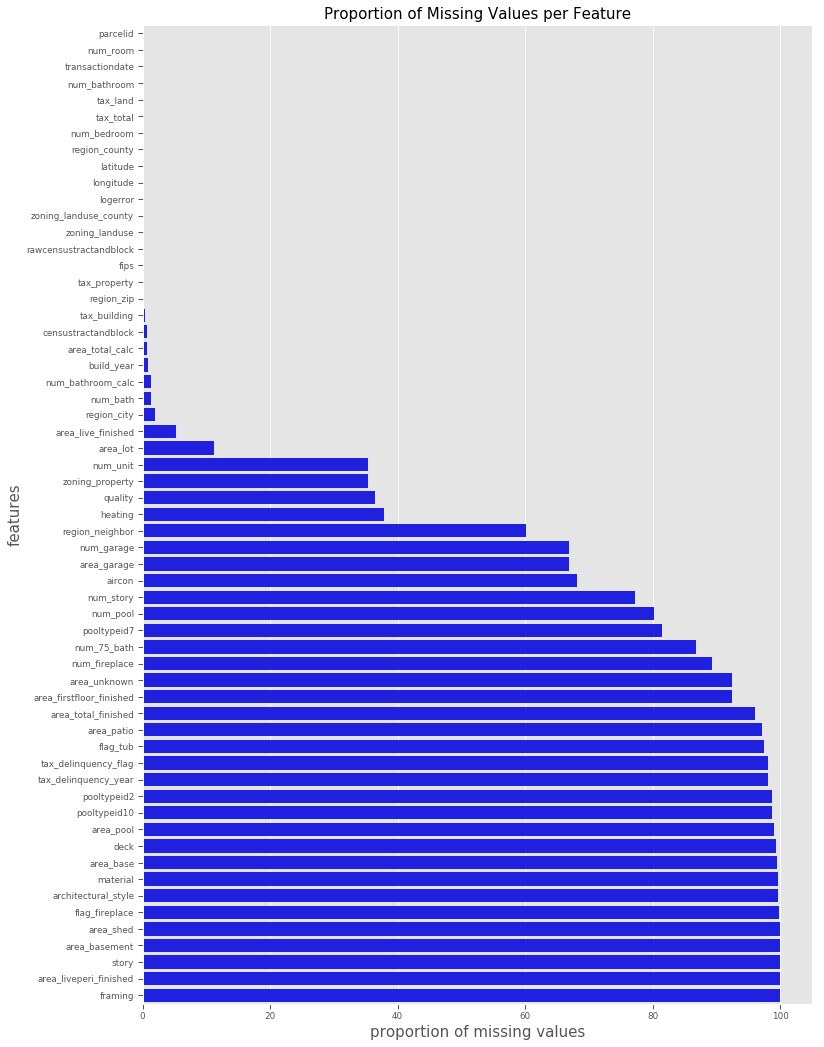

In [57]:
sns.set_context("paper", rc={"figure.figsize":(8,6), "font.size":10,"axes.titlesize":20,"axes.labelsize":15})  

# set an appropriate figure size
plt.subplots(figsize=(12, 18))

# barplot
ax = sns.barplot(x="prop_missing_values", 
            y="features", 
            data= missing_values_df.reset_index().sort_values(by = 'prop_missing_values', ascending=True),
            label="prop_missing_values", 
            color="b")



# set axis labels
ax.set(xlabel='proportion of missing values', ylabel='features')

# set title
ax.set_title("Proportion of Missing Values per Feature", fontsize = 15)


It is not necessary to keep all the features, especially the ones with a high percentage of missing values. Keeping them would imply we would need to do lots of imputation on them and imputation introduces artificial (and maybe unreliable) information in the dataset.

Here we decide to keep features that have less than 75% missing values. 

In [58]:
features_to_keep = list(missing_values_df[missing_values_df['prop_missing_values'] < 75].index)
sorted(features_to_keep)

['aircon',
 'area_garage',
 'area_live_finished',
 'area_lot',
 'area_total_calc',
 'build_year',
 'censustractandblock',
 'fips',
 'heating',
 'latitude',
 'logerror',
 'longitude',
 'num_bath',
 'num_bathroom',
 'num_bathroom_calc',
 'num_bedroom',
 'num_garage',
 'num_room',
 'num_unit',
 'parcelid',
 'quality',
 'rawcensustractandblock',
 'region_city',
 'region_county',
 'region_neighbor',
 'region_zip',
 'tax_building',
 'tax_land',
 'tax_property',
 'tax_total',
 'transactiondate',
 'zoning_landuse',
 'zoning_landuse_county',
 'zoning_property']

This leaves us with 34 features (if we exclude parcelid which is just kind of an index).

In [61]:
# create a new dataframe by keeping only features whose missing values < 75
df_no_missv = df.loc[:, features_to_keep]
sorted(list(df_no_missv.columns))

['aircon',
 'area_garage',
 'area_live_finished',
 'area_lot',
 'area_total_calc',
 'build_year',
 'censustractandblock',
 'fips',
 'heating',
 'latitude',
 'logerror',
 'longitude',
 'num_bath',
 'num_bathroom',
 'num_bathroom_calc',
 'num_bedroom',
 'num_garage',
 'num_room',
 'num_unit',
 'parcelid',
 'quality',
 'rawcensustractandblock',
 'region_city',
 'region_county',
 'region_neighbor',
 'region_zip',
 'tax_building',
 'tax_land',
 'tax_property',
 'tax_total',
 'transactiondate',
 'zoning_landuse',
 'zoning_landuse_county',
 'zoning_property']

## Analyze, Identify and Explore the Data

### Correlation between features and target variable "logerror"

#### Correlation between "area" features and target variable "logerror"

In [62]:
# create list of "area" features
list_area_features = list(df_no_missv.loc[:, df_no_missv.columns.str.contains("area")].columns)

In [68]:
# append "logerror"
list_area_features.append('logerror')
list_area_features

['area_garage',
 'area_lot',
 'area_live_finished',
 'area_total_calc',
 'logerror',
 'logerror']

Let's now create a correlation plot to see what is the extent of the linear association between each of the "area" variables and the *logerror*.

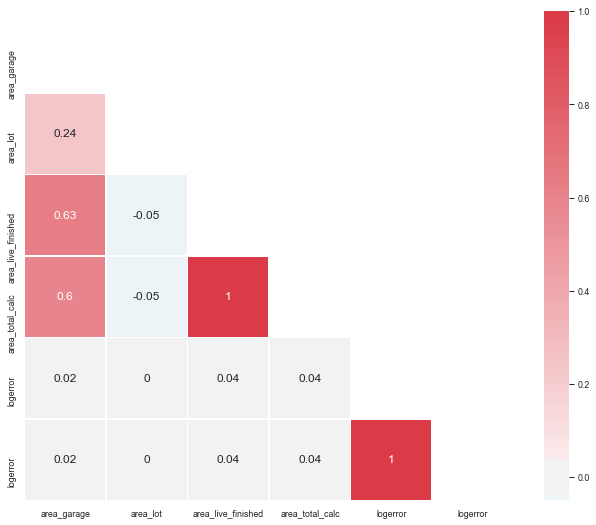

In [69]:
# change ploting style
sns.set_style('whitegrid')

# create correlation between "area" features and "logerror"
corr_area = df_no_missv.loc[:, list_area_features].corr().round(2)

# generate a mask for the upper triangle
mask = np.zeros_like(corr_area, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_area, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, annot = True, annot_kws={"size": 12})

The correlations between the "area" features and the logerror seem to be very low.

On another note, we can notice that there seem to be a perfect linear association between *area_live_finished* and *area_total_calc*. To avoid collinearity we need to remove one of the features.

In [70]:
df_no_missv[['area_total_calc', 'area_live_finished']].head()

,area_total_calc,area_live_finished
0,1684.0,1684.0
1,2263.0,2263.0
2,2217.0,2217.0
3,839.0,839.0
4,2283.0,2283.0


In [71]:
# number of rows
len(df_no_missv['area_total_calc'])

# number of rows with equal values for these variables
sum(df_no_missv['area_total_calc'] == df_no_missv['area_live_finished'])

90275

85596

In [72]:
# drop area_live_finished
list_area_features.remove('area_live_finished')

# drop logerror
list_area_features.remove('logerror')

# drop area_live_finished in df_no_missv
df_no_missv.drop('area_live_finished', axis = 1, inplace = True)

#### Correlation between "num" features and target variable "logerror"

In [73]:
# create list of "num" features
list_num_features = list(df_no_missv.loc[:, df_no_missv.columns.str.contains("num")].columns)

In [74]:
# append "logerror"
list_num_features.append('logerror')
list_num_features

['num_garage',
 'num_unit',
 'num_bath',
 'num_bathroom_calc',
 'num_room',
 'num_bathroom',
 'num_bedroom',
 'logerror']

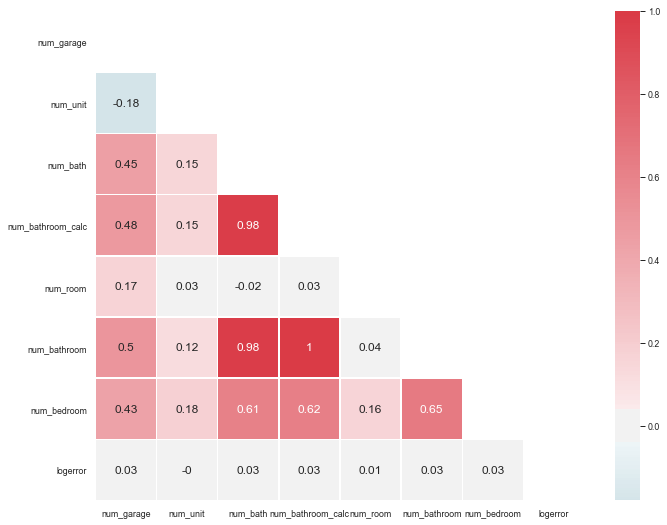

In [75]:
# change ploting style
sns.set_style('whitegrid')

# create correlation between "num" features and "logerror"
corr_num = df_no_missv.loc[:, list_num_features].corr().round(2)

# generate a mask for the upper triangle
mask = np.zeros_like(corr_num, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_num, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, annot = True, annot_kws={"size": 12})

Here as well the correlation between the *logerror* and other "num" features seem to be very low.

(*num_bathroom* or *num_bathroom_calc*) and (*num_bath or *num_bathroom_calc*) needs to be removed to avoid collinearity.

In [76]:
df_no_missv[['num_bathroom', 'num_bathroom_calc', 'num_bath']].head()

,num_bathroom,num_bathroom_calc,num_bath
0,2.0,2.0,2.0
1,3.5,3.5,3.0
2,3.0,3.0,3.0
3,2.0,2.0,2.0
4,2.5,2.5,2.0


In [77]:
# number of rows
len(df_no_missv['num_bathroom'])

# number of rows with equal values for these variables
sum(df_no_missv['num_bathroom'] == df_no_missv['num_bath'])

90275

77084

In [78]:
# drop num_bathroom
list_num_features.remove('num_bathroom')

# drop num_bathroom_calc
list_num_features.remove('num_bathroom_calc')

# drop logerror
list_num_features.remove('logerror')

# drop num_bathroom & num_bathroom_calc
df_no_missv.drop(['num_bathroom', 'num_bathroom_calc'], axis = 1, inplace = True)

#### Correlation between "tax" features and target variable "logerror"

In [79]:
# create list of "tax" features
list_tax_features = list(df_no_missv.loc[:, df_no_missv.columns.str.contains("tax")].columns)

In [80]:
# append "logerror"
list_tax_features.append('logerror')
list_tax_features

['tax_building', 'tax_property', 'tax_land', 'tax_total', 'logerror']

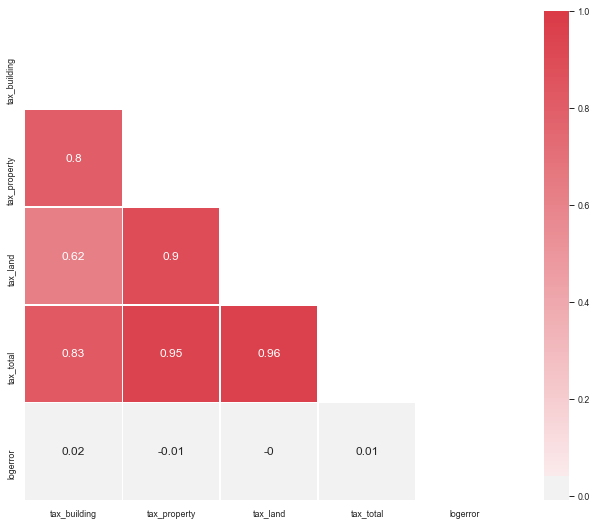

In [81]:
# change ploting style
sns.set_style('whitegrid')

# create correlation between "tax" features and "logerror"
corr_tax = df_no_missv.loc[:, list_tax_features].corr().round(2)

# generate a mask for the upper triangle
mask = np.zeros_like(corr_tax, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_tax, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, annot = True, annot_kws={"size": 12})

Again the correlation between the "tax" features and *logerror* is really small.

In [82]:
# drop tax_total
list_tax_features.remove('tax_total')

# drop logerror
list_tax_features.remove('logerror')

# drop tax_total
df_no_missv.drop('tax_total', axis = 1, inplace=True)

### Outliers

Outliers need to be removed when building a predictive model as extreme values might lead the model to overfit.

We are plotting boxplots to the diverse range of variables considered to visually confirm the existence of outliers.

#### Area Variables

In [83]:
list_area_features

['area_garage', 'area_lot', 'area_total_calc', 'logerror']

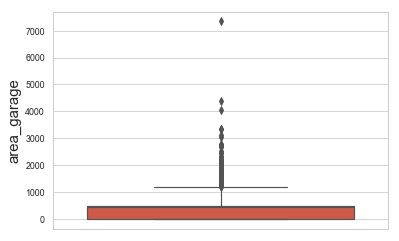

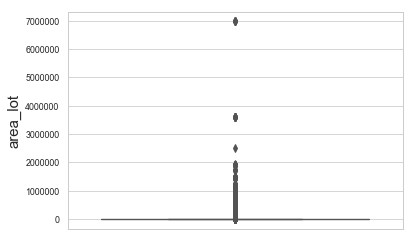

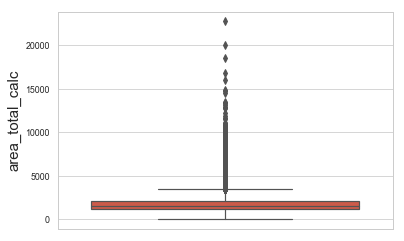

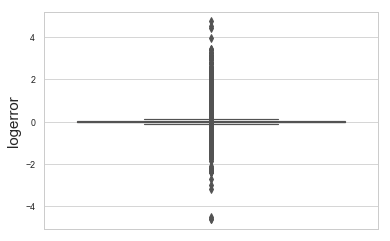

In [84]:
# plot boxplots
for i in range(len(list_area_features)):
    ax = sns.boxplot(df_no_missv.loc[:,list_area_features[i]], orient = "v")
    plt.show(ax)

We can notice right skewed distribution and many observations lying above the top whiskers, confirming the presence of outliers.

#### Num Variables

In [96]:
list_num_features

['num_garage', 'num_unit', 'num_bath', 'num_room', 'num_bedroom']

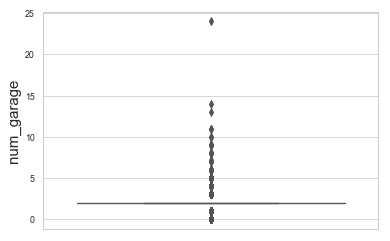

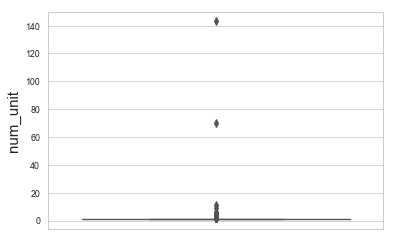

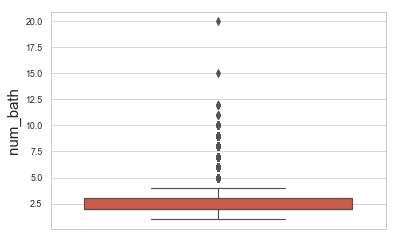

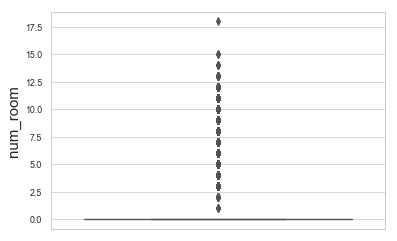

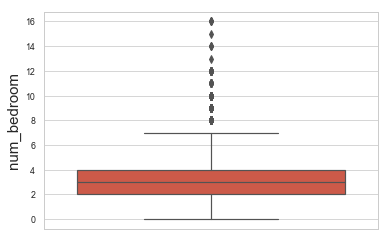

In [97]:
# plot boxplots
for i in range(len(list_num_features)):
    ax = sns.boxplot(df_no_missv.loc[:,list_num_features[i]], orient = "v")
    plt.show(ax)

Again the boxplots suggest a strong presence of outliers.

#### Tax Variables

In [98]:
list_tax_features

['tax_building', 'tax_property', 'tax_land']

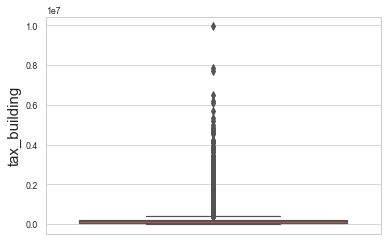

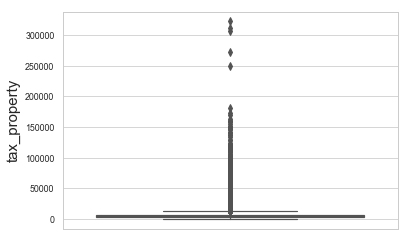

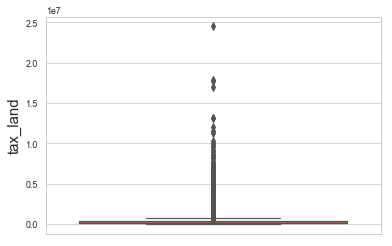

In [99]:
# plot boxplots
for i in range(len(list_tax_features)):
    ax = sns.boxplot(df_no_missv.loc[:,list_tax_features[i]], orient = "v")
    plt.show(ax)

#### Remove Outliers

In [102]:
list_features_with_outliers = list_area_features + \
                                list_num_features + \
                                list_tax_features

In [103]:
list_features_with_outliers

['area_garage',
 'area_lot',
 'area_total_calc',
 'logerror',
 'num_garage',
 'num_unit',
 'num_bath',
 'num_room',
 'num_bedroom',
 'tax_building',
 'tax_property',
 'tax_land']

In [104]:
# build 1st and 3rd quartiles
Q1 = df_no_missv.loc[:, list_features_with_outliers].quantile(0.25)
Q3 = df_no_missv.loc[:, list_features_with_outliers].quantile(0.75)

# build the interquartile range (IQR)
IQR = Q3 - Q1

print(IQR)

area_garage           484.0000
area_lot             5983.0000
area_total_calc       911.0000
logerror                0.0645
num_garage              0.0000
num_unit                0.0000
num_bath                1.0000
num_room                0.0000
num_bedroom             2.0000
tax_building       129289.5000
tax_property         4028.2600
tax_land           263191.5000
dtype: float64


In [105]:
# remove outliers outside of the whiskers
df_no_out = df_no_missv[~((df_no_missv.loc[:, list_features_with_outliers] < (Q1 - 1.5 * IQR)) |\
                          (df_no_missv.loc[:, list_features_with_outliers] > (Q3 + 1.5 * IQR)))\
                        .any(axis=1)]

In [106]:
# dimension of the new dataset
df_no_out.shape

(39539, 30)

The new dataframe is approximately half the size of the previous dataframe.

In [107]:
df_no_out.head()

,aircon,area_garage,num_garage,region_neighbor,heating,quality,zoning_property,num_unit,area_lot,region_city,...,num_bedroom,fips,latitude,longitude,logerror,zoning_landuse_county,zoning_landuse,rawcensustractandblock,region_county,parcelid
0,1.0,NaN,NaN,31817.0,2.0,4.0,LARS,1.0,7528.0,12447.0,...,3.0,6037.0,34280990.0,-118488536.0,0.0276,0100,261.0,6.037107e+07,3101.0,11016594
2,1.0,NaN,NaN,275411.0,2.0,4.0,PSR6,1.0,11423.0,47019.0,...,2.0,6037.0,34136312.0,-118175032.0,-0.0040,0100,261.0,6.037464e+07,3101.0,12098116
6,NaN,NaN,NaN,NaN,7.0,7.0,CORH*,1.0,6677.0,24174.0,...,2.0,6037.0,33899475.0,-118212720.0,0.0440,0100,261.0,6.037542e+07,3101.0,12286022
12,NaN,NaN,NaN,NaN,7.0,7.0,BUR1*,1.0,8214.0,396054.0,...,3.0,6037.0,34189804.0,-118339183.0,0.0344,0100,261.0,6.037311e+07,3101.0,10949761
13,NaN,NaN,NaN,273096.0,NaN,NaN,NaN,NaN,NaN,52650.0,...,2.0,6059.0,33670900.0,-117844000.0,0.0816,1,266.0,6.059063e+07,1286.0,14665244


Census tract and block could be investigated in the future as they might ease the process of identifying outliers.

In [110]:
df_no_missv[['rawcensustractandblock', 'censustractandblock']].head()

,rawcensustractandblock,censustractandblock
0,6.037107e+07,6.037107e+13
1,6.059052e+07,NaN
2,6.037464e+07,6.037464e+13
3,6.037296e+07,6.037296e+13
4,6.059042e+07,6.059042e+13


**Definitions**:

* census blocks:

They are statistical areas bounded by visible features, such as streets, roads, streams, and railroad tracks, and by non-visible boundaries, such as selected property lines and city, township, school district, and county limits.

* census block group

It is a cluster of census blocks having the same first digit of their four-digit identifying numbers within a census tract. Block groups generally contain between 600 and 3,000 people, with an optimum size of 1,500 people. There are about 39 blocks per census group. Block groups never cross the boundaries of states, counties, or statistically equivalent entities, except for a block group delineated by American Indian tribal authorities. Each census tract contains at least one block group, and block groups are uniquely numbered within the census tract. A block group is the smallest geographical unit for which the census publishes sample data.

* census tracts

They are small, relatively permanent statistical subdivisions of a county delineated by local participants as part of the U.S. Census Bureau’s Participant Statistical Areas Program. Census tracts were first used in the 2000 census. Census tracts generally have between 1,500 and 8,000 people, with an optimum size of 4,000 people. Census tracts are identified by a four-digit basic number and may have a two-digit numeric suffix. 


### Distribution of Transactions

Let’s first create the *year_month* feature:

In [114]:
# create year, month and year-month variable
df_no_out['year'] = pd.DatetimeIndex(df_no_out['transactiondate']).year
df_no_out['month'] = pd.DatetimeIndex(df_no_out['transactiondate']).strftime("%m") 
df_no_out['year_month'] = df_no_out['year'].astype(str) + '-' + df_no_out['month'].astype(str)

[Text(0, 0.5, 'Counts'), Text(0.5, 0, 'Year-Month')]

[Text(0, 0, '2016-01'),
 Text(0, 0, '2016-02'),
 Text(0, 0, '2016-03'),
 Text(0, 0, '2016-04'),
 Text(0, 0, '2016-05'),
 Text(0, 0, '2016-06'),
 Text(0, 0, '2016-07'),
 Text(0, 0, '2016-08'),
 Text(0, 0, '2016-09'),
 Text(0, 0, '2016-10'),
 Text(0, 0, '2016-11'),
 Text(0, 0, '2016-12')]

Text(0.5, 1.0, 'Number of Transactions per Year-Month')

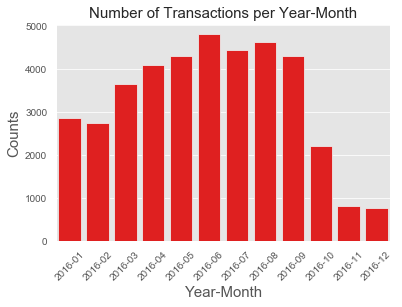

In [119]:
# set context
sns.set_context("paper", rc={"figure.figsize":(8,6), "font.size":10,"axes.titlesize":20,"axes.labelsize":15})  

# number of transactions per year-month
year_month_counts = df_no_out.groupby(by=['year_month']).size().reset_index(name='counts')

# plot graph
ax = sns.barplot(x= "year_month", y="counts", data = year_month_counts, color = "red")

# set axis labels
ax.set(xlabel='Year-Month', ylabel='Counts')

# set tick labels
ax.set_xticklabels(rotation=45, labels = year_month_counts["year_month"])
ax.tick_params(labelsize=10)

# set title
ax.set_title("Number of Transactions per Year-Month", fontsize = 15)


### How does the *abs_logerror* change with *year_month*?

In [120]:
# create the absolute logerror column
df_no_out['abs_logerror'] = abs(df_no_out['logerror'])


# mean abs_logerror and sum per year_month
year_month_abslogerror = df_no_out.groupby(by=['year_month'])\
                            .agg({'abs_logerror': {'mean_abs_logerror': 'mean', 'sum': 'sum'}})
# drop abs_logerror level                            
year_month_abslogerror.columns = year_month_abslogerror.columns.droplevel(0)

# reset index
year_month_abslogerror.reset_index(level = 0, inplace=True)

# print
print(year_month_abslogerror)                     

   year_month  mean_abs_logerror       sum
0     2016-01           0.036855  105.4414
1     2016-02           0.036475  100.0139
2     2016-03           0.036586  133.0995
3     2016-04           0.036015  146.7591
4     2016-05           0.036016  154.9779
5     2016-06           0.035820  172.1163
6     2016-07           0.034761  154.0270
7     2016-08           0.035297  162.7531
8     2016-09           0.036265  155.4696
9     2016-10           0.034164   75.5017
10    2016-11           0.036887   30.1734
11    2016-12           0.035495   26.9050


(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a305f8940>)

[Text(0, 0.5, 'abs_logerror mean'), Text(0.5, 0, 'year-month')]

[Text(0, 0.5, 'abs_logerror sum')]

[Text(0, 0, '2016-01'),
 Text(0, 0, '2016-02'),
 Text(0, 0, '2016-03'),
 Text(0, 0, '2016-04'),
 Text(0, 0, '2016-05'),
 Text(0, 0, '2016-06'),
 Text(0, 0, '2016-07'),
 Text(0, 0, '2016-08'),
 Text(0, 0, '2016-09'),
 Text(0, 0, '2016-10'),
 Text(0, 0, '2016-11'),
 Text(0, 0, '2016-12')]

Text(0.5, 1.0, 'Mean and Sum of abs_logerror over Year-Month')

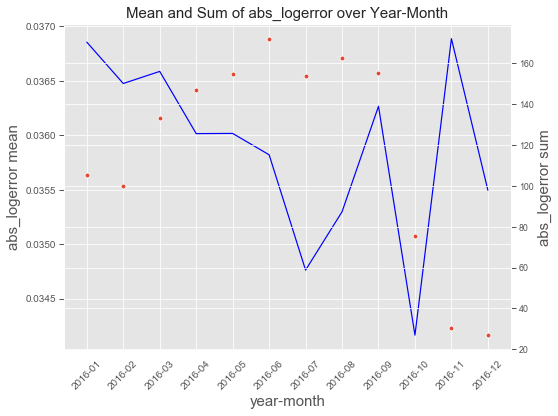

In [123]:
# set context
sns.set_context("paper", rc={"figure.figsize":(8,6), "font.size":10,"axes.titlesize":20,"axes.labelsize":15})  

# set an appropriate figure size
plt.subplots(figsize=(8, 6))

# plot monthly mean absolute error 
ax = sns.lineplot(x= "year_month", 
                  y="mean_abs_logerror", 
                  data = year_month_abslogerror, 
                  color = "blue")

# set second axis
ax2 = ax.twinx()

# plot monthly absolute error sum
sns.scatterplot(x = "year_month", 
                y = "sum", 
                ax = ax2, 
                data = year_month_abslogerror)

# set axis labels
ax.set(xlabel='year-month', ylabel='abs_logerror mean')
ax2.set(ylabel='abs_logerror sum')
# set tick labels
ax.set_xticklabels(rotation=45, labels = year_month_abslogerror["year_month"])
ax.tick_params(labelsize=10)

# set title
ax.set_title("Mean and Sum of abs_logerror over Year-Month", fontsize = 15)

plt.show()

The mean of *abs_logerror* seems to be the smallest during July and October.

### When were houses built?

[Text(0, 0.5, 'Density'), Text(0.5, 0, 'Build Year')]

Text(0.5, 1.0, 'Build Year Density')

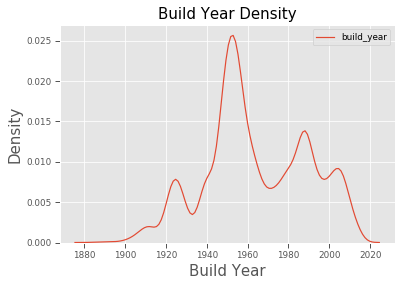

In [151]:
# set context
sns.set_context("paper", rc={"figure.figsize":(8,6), "font.size":10,"axes.titlesize":20,"axes.labelsize":15})  

# plot density
ax = sns.kdeplot(df_no_out["build_year"], vertical=False)

# set axis labels
ax.set(xlabel='Build Year', ylabel='Density')

# set title
ax.set_title("Build Year Density", fontsize = 15)

### How does the mean *abs_logerror* change with *build_year*?

In [124]:
# mean abs_logerror and sum per year_month
build_year_abslogerror = df_no_out.groupby(by=['build_year'])\
                            .agg({'abs_logerror': {'mean_abs_logerror': 'mean'}})
# drop abs_logerror level                            
build_year_abslogerror.columns = build_year_abslogerror.columns.droplevel(0)

# reset index
build_year_abslogerror.reset_index(level = 0, inplace=True)

# print
build_year_abslogerror.head()  

,build_year,mean_abs_logerror
0,1885.0,0.04412
1,1886.0,0.00100
2,1887.0,0.00800
3,1888.0,0.06920
4,1890.0,0.05230


[Text(0, 0.5, 'density'), Text(0.5, 0, 'build year')]

KeyError: 'build_year'

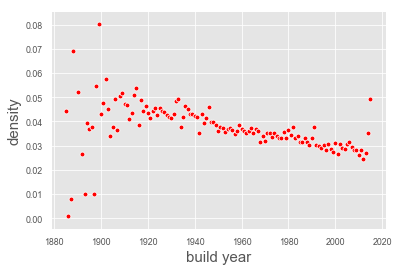

In [126]:
# set context
sns.set_context("paper", rc={"figure.figsize":(8,6), "font.size":10,"axes.titlesize":20,"axes.labelsize":15})  

# graph
ax = sns.scatterplot(x= "build_year", y="mean_abs_logerror", data = build_year_abslogerror, color = "red")

# set x and y axis labels
ax.set(xlabel='build year', ylabel='density')

# set tick labels
ax.set_xticklabels(rotation=45, labels = year_month_abslogerror["build_year"])
ax.tick_params(labelsize=5)

# set title
ax.set_title("Mean Absolute logerror Density over Build Year", fontsize = 15)

It seems that the greatest prediction errors are related to houses built before 1920. It is probably worth removing these houses from our dataframe.

### Where does Zestimate predict well?

In [127]:
# create percentiles
df_no_out['percentile'] = pd.qcut(df_no_out['abs_logerror'], \
                           [0, 0.1, 0.25, 0.75, 0.9, 1], \
                           labels = ['best_fit', 'good_fit', 'typical_fit', 'bad_fit', 'worst_fit'])

In [128]:
df_no_out['over_under'] = np.where(df_no_out['logerror'] > 0, 'over', 'under')

In [129]:
df_no_out['over_under'].value_counts()

over     21179
under    18360
Name: over_under, dtype: int64

Around 54% of the house prices have been overestimated and 46% underestimated.

### Latitude

[Text(21.200000000000003, 0.5, 'density'),
 Text(0.5, 21.200000000000003, 'latitude')]

Text(0.5, 1.0, 'Latitude Density')

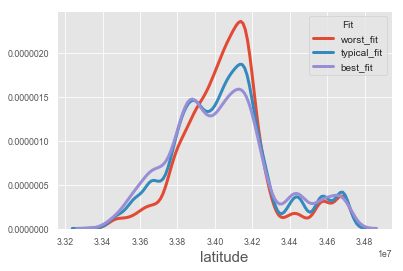

In [130]:
# set context
sns.set_context("paper", rc={"figure.figsize":(8,6), "font.size":10,"axes.titlesize":20,"axes.labelsize":15})  

# fit types we are interested in plotting
fit_type = ['worst_fit', 'typical_fit', 'best_fit']

# plot the different densities
for i in fit_type :
    data = df_no_out[df_no_out['percentile'] == i]
    
    # Draw the density plot
    sns.distplot(data["latitude"],
                 hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = i)

# set legends
plt.legend(prop={'size': 10}, title = 'Fit')
    
# set axis labels
ax.set(xlabel='latitude', ylabel='density')

# set title
ax.set_title("Latitude Density", fontsize = 15)

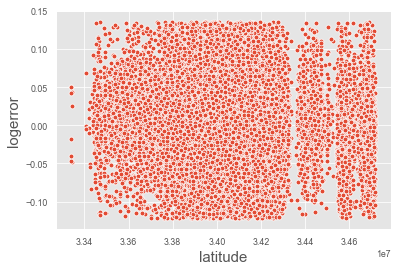

In [131]:
# plot latitude versus logerror
sns.scatterplot(x = "latitude", y = "logerror", data = df_no_out)

Prices are especially wrongly predicted where the peak of the *worst_fit* curve is. It would be interesting to see on a map where this is and see if there is some rationale for it that could help our model to better predict house prices in this area.

### Longitude

[Text(21.200000000000003, 0.5, 'density'),
 Text(0.5, 21.200000000000003, 'longitude')]

Text(0.5, 1.0, 'Longitude Density')

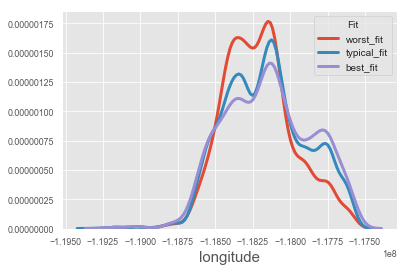

In [132]:
# set context
sns.set_context("paper", rc={"figure.figsize":(8,6), "font.size":10,"axes.titlesize":20,"axes.labelsize":15})  

# fit types we are interested in plotting
fit_type = ['worst_fit', 'typical_fit', 'best_fit']


for i in range(len(fit_type)) :
        data = df_no_out[df_no_out['percentile'] == fit_type[i]]
    
        # Draw the density plot
        sns.distplot(data["longitude"],
                     hist = False, kde = True,
                     kde_kws = {'linewidth': 3},
                     label = fit_type[i])
                     #color = colors[i])

# set legends
plt.legend(prop={'size': 10}, title = 'Fit')
    
# set axis labels
ax.set(xlabel='longitude', ylabel='density')

# set title
ax.set_title("Longitude Density", fontsize = 15)

Here as well we can observe the longitudes where the worst fit are. The graph below plots the logerrors.

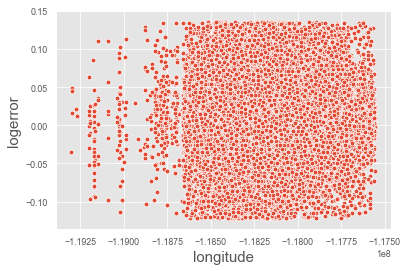

In [133]:
# plot longitude versus logerror
sns.scatterplot(x = "longitude", y = "logerror", data = df_no_out)


Let's now remove observations where houses were built before the 1920s.

In [134]:
df_no_out.shape

(39539, 36)

In [135]:
df_no_out = df_no_out[df_no_out["build_year"] > 1920]

In [136]:
df_no_out.shape

(38121, 36)

## Model, Predict and Solve the Problem

In [137]:
df_no_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38121 entries, 0 to 90273
Data columns (total 36 columns):
aircon                    12584 non-null float64
area_garage               5229 non-null float64
num_garage                5229 non-null float64
region_neighbor           16412 non-null float64
heating                   32135 non-null float64
quality                   32366 non-null float64
zoning_property           32406 non-null object
num_unit                  32421 non-null float64
area_lot                  33988 non-null float64
region_city               37405 non-null float64
num_bath                  38071 non-null float64
build_year                38121 non-null float64
area_total_calc           38116 non-null float64
censustractandblock       37983 non-null float64
tax_building              38105 non-null float64
region_zip                38118 non-null float64
tax_property              38117 non-null float64
num_room                  38121 non-null float64
transactiond

### Preprocessing

There are a few features that were created using the *logerror* for exploration. We can now remove them, as well as *transaction_date*, as we extracted the *month* and *year* feature from it. These two features will be used on the *Sample_submission* dataset to predict *logerror* for relevant periods. 

In [138]:
list_features_to_remove = ['abs_logerror', 
                           'percentile', 
                           'over_under',  
                           'year_month',
                           'transaction_date']
df_no_out = df_no_out.loc[:, ~(df_no_out.columns.isin(list_features_to_remove))]

When preparing the dataset for modeling, we will scale the numeric features. Why shall we do that?

* features on larger scales can unduly influence the model
* many models utilise some form of distance to inform them

As most machine learning models can only process numeric features, categorical features need to be transformed into some kind of numerical format via an encoder.

As seen above, we still have two "object" features that will need be encoded: 
* *zoning_landuse_county*
* *zoning_property*

There exists two types of categorical features encoding:
* LabelEncoder
Converts a categorical column of strings into integers as an ordinal feature.
* OneHotEncoder
This method transforms categorical features into dummies (number of dummmies = number of levels in that categorical feature).


In [142]:
#LabelEncoder encoding
for c in df_no_out.columns:
    df_no_out[c]=df_no_out[c].fillna(-1)
    if df_no_out[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(df_no_out[c].values))
        df_no_out[c] = lbl.transform(list(df_no_out[c].values))

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

The *Properties* dataset is used as the dataset that we want to predict the *logerror* of. It needs to be similar to the dataset that was used to build the model then:

In [144]:
# features list that will be used in the Properties dataset
features_list = list(df_no_out.columns)
features_list.remove('logerror')

# features used
properties_used_to_predict = properties.loc[:, features_list]

# apply LabelEncoder to categorical columns of the Properties dataset
#properties_used_to_predict[categorical_columns] = properties_used_to_predict[categorical_columns].apply(lambda x: le.fit_transform(x))

In [145]:
for c in properties_used_to_predict.columns:
    properties_used_to_predict[c]=properties_used_to_predict[c].fillna(-1)
    if properties_used_to_predict[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(properties_used_to_predict[c].values))
        properties_used_to_predict[c] = lbl.transform(list(properties_used_to_predict[c].values))

LabelEncoder()

LabelEncoder()

### Train and test sets

In [146]:
# set paramters
seed = 7
test_size = 0.2

# create X and y
X = df_no_out.loc[:, ~ (df_no_out.columns.isin(['logerror']))]
y = df_no_out['logerror']



# create the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        test_size = 0.2, random_state = seed)


y_mean = np.mean(y_train)

# convert the train and test sets to input usable by xgboost
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

In [149]:
# set parameters
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5, 
                          alpha = 10, 
                          n_estimators = 10)
# fit the model
xg_reg.fit(X_train,y_train)

# create predictions
preds = xg_reg.predict(X_test)

# evaluation
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

RMSE: 0.179095


In [150]:
xgb_params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': y_mean,
    'silent': 1
}

In [153]:
num_boost_rounds = 242

print("num_boost_rounds="+str(num_boost_rounds))

# train model
print( "\nTraining XGBoost ...")
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)

print( "\nPredicting with XGBoost ...")
xgb_pred = model.predict(dtest)

print( "\nXGBoost predictions:" )
print( pd.DataFrame(xgb_pred).head() )

num_boost_rounds=242

Training XGBoost ...

Predicting with XGBoost ...

XGBoost predictions:
          0
0  0.001066
1  0.001092
2  0.010849
3  0.009894
4  0.014267


In [154]:
# set the target months
target_years = [2016, 2017]
target_months = [10, 11, 12]

# loop over the test set and predict
for i in target_years: 
    for j in target_months:
        properties_used_to_predict['year'] = i
        properties_used_to_predict['month'] = j
        dtest = xgb.DMatrix(properties_used_to_predict)
        sample_submission.loc[:, str(i) + str(j)] = model.predict(dtest)

## Visualise, Report and Present the Problem Solving Steps and Final Solution

To visualise our model, we can examine the importance of each feature column in the original dataset within the model.

One simple way of doing this involves counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear.

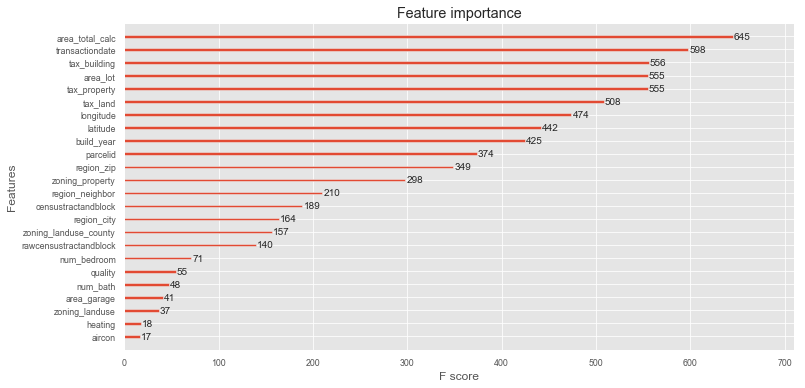

In [156]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(12, 6)

In [264]:
#plot_tree(model)

In [250]:
sample_submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.015424,0.015424,0.016816,0.015424,0.015424,0.016816
1,10759547,0.130124,0.130124,0.130589,0.130124,0.130124,0.130589
2,10843547,0.212892,0.207477,0.197981,0.212892,0.207477,0.197981
3,10859147,0.066190,0.064669,0.063856,0.066190,0.064669,0.063856
4,10879947,-0.017346,-0.017346,-0.021783,-0.017346,-0.017346,-0.021783


In [252]:
sample_submission.shape

(2985217, 7)

## Suply or submit the results

In [255]:
from datetime import datetime
print( "\nWriting results to disk ..." )
sample_submission.to_csv('sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)


Writing results to disk ...
